In [1]:
import os, time, h5py, platform, json, sys
sys.path.append("/Users/gkoolstra/Documents/Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from termcolor import cprint
from Common import common, kfit
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

Double, passive low pass filter. 

# Load the data

In [42]:
datapath = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/171130/Dsub FilterBoard in Box.csv"
data = common.load_csv(datapath, header_length=1, ncols=13, footer_length=0)
f = data[:-2, 0]
pins_response = data[:-2, 1:] / 2.06 # Normalize

In [43]:
def transfer_function(x, *p):
    R, C = p
    return np.abs(1 / (1 + 1j * 2 * np.pi * x * R * C)) ** 2

def log_transfer_function(x, *p):
    R, C = p
    return np.log10(np.abs(1 / (1 + 1j * 2 * np.pi * x * R * C)) ** 2)

In [58]:
# Fit
fr, ferr = kfit.fitbetter(f, np.log10(pins_response[:, 0]), log_transfer_function, fitparams=[1e2, 20E-9])
print(fr)

fr_lin, ferr_lin = kfit.fitbetter(f, pins_response[:, 0], transfer_function, fitparams=[1e2, 20E-9])
print(fr_lin)

[  1.97847928e+03   2.38528499e-07]
[  8.73968246e+02   7.81938249e-07]


Assuming log fit gives cut-off frequency =  337.247197613
Assuming linear fit gives cut-off frequency =  232.89063245
Given components, I would assume cut-off frequency =  331.5727981081153


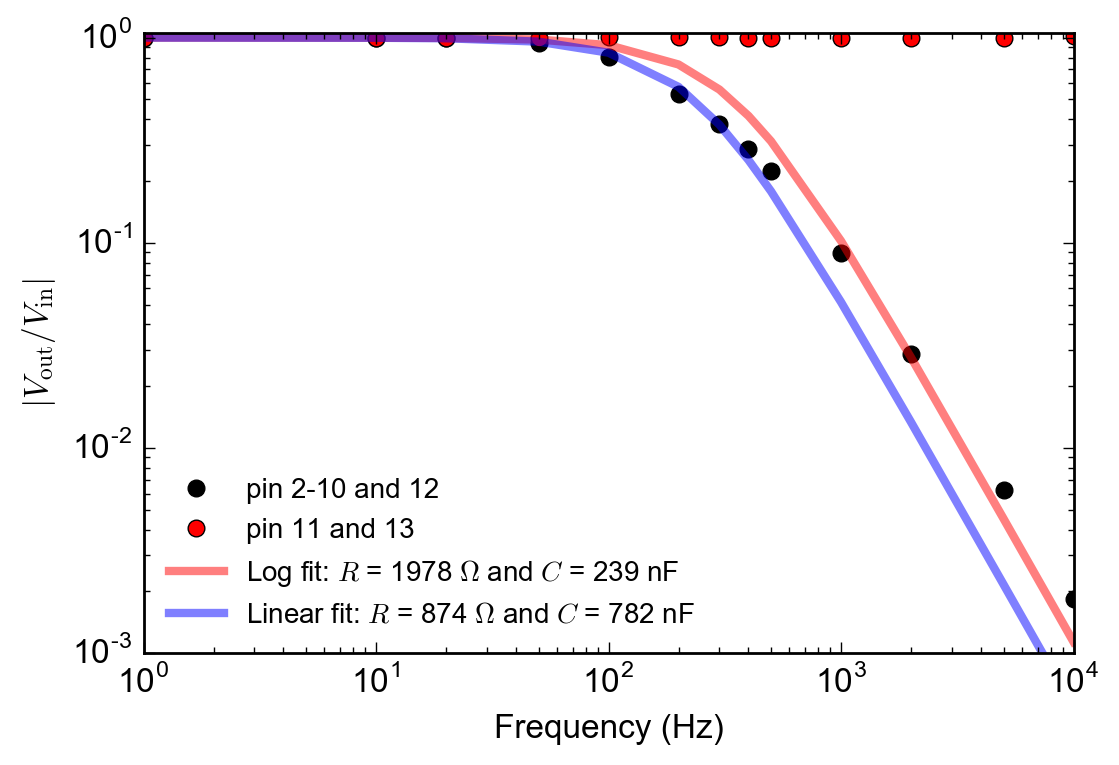

In [69]:
fig = plt.figure()
common.configure_axes(12)
plt.plot(f, pins_response[:, 0], 'ok', label="pin 2-10 and 12")
plt.plot(f, pins_response[:, 11], 'or', label="pin 11 and 13")
plt.plot(f, transfer_function(f, *fr), '-r', lw=3, alpha=0.5, 
         label=r"Log fit: $R$ = %.0f $\Omega$ and $C$ = %.0f nF" % (fr[0], fr[1] * 1E9))
plt.plot(f, transfer_function(f, *fr_lin), '-b', lw=3, alpha=0.5, 
         label=r"Linear fit: $R$ = %.0f $\Omega$ and $C$ = %.0f nF" % (fr_lin[0], fr_lin[1] * 1E9))

plt.xscale('log')
plt.yscale('log')
plt.ylim(1E-3, 1.05)
plt.ylabel("$|V_\mathrm{out}/V_\mathrm{in}|$")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=3, frameon=False, prop={"size" : 10}, numpoints=1)

print("Assuming log fit gives cut-off frequency = ", (1/(2*np.pi*fr[0]*fr[1])))
print("Assuming linear fit gives cut-off frequency = ", (1/(2*np.pi*fr_lin[0]*fr_lin[1])))

print("Given components, I would assume cut-off frequency = ", (1/(2*np.pi*1E3*480E-9)))

# common.save_figure(fig, save_path=os.path.split(datapath)[0])